# Comparison of SBP-SAT and SPECFEM2D in a two-layers medium

In [1]:
import numpy as np
from scipy import signal
import math
import matplotlib.pyplot as plt
from matplotlib import rcParams

### Wavefield figures

In [2]:
# load acoustic and elastic wavefields generated by SBP-SAT method
awfld = np.load('../dat/fd_data.wflda.npy') # fluid momentum potential
ewfld = np.load('../dat/fd_data.wfld.npy') # solid particle displacement

In [3]:
# compute particle velocity magnitude in each medium and concatenate the two wavefields for two given time snapshots
nt=5001
dt=0.0005
ot=0.
it1 = 12
it2 = 24
sub=100
awfld1=awfld[it1,:,:]
awfld2=awfld[it2,:,:]
ewfld1=(ewfld[it1+1,:,:,:]-ewfld[it1-1,:,:,:])/(2*sub*dt)
ewfld2=(ewfld[it2+1,:,:,:]-ewfld[it2-1,:,:,:])/(2*sub*dt)

# the gradient of the acoustic wavefield (momentum potential) divided by water density (=1 in this case) yields particle velocity in the acoustic medium
dx=0.005
dz=0.005
va1 = np.gradient(awfld1,dx,dz)
va2 = np.gradient(awfld2,dx,dz)

va1 = np.sqrt(np.square(va1[0])+np.square(va1[1]))
va2 = np.sqrt(np.square(va2[0])+np.square(va2[1]))
ve1 = np.sqrt(np.square(ewfld1[0,:,:])+np.square(ewfld1[1,:,:]))
ve2 = np.sqrt(np.square(ewfld2[0,:,:])+np.square(ewfld2[1,:,:]))

v1 = np.concatenate((va1,ve1),axis=1)
v2 = np.concatenate((va2,ve2),axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


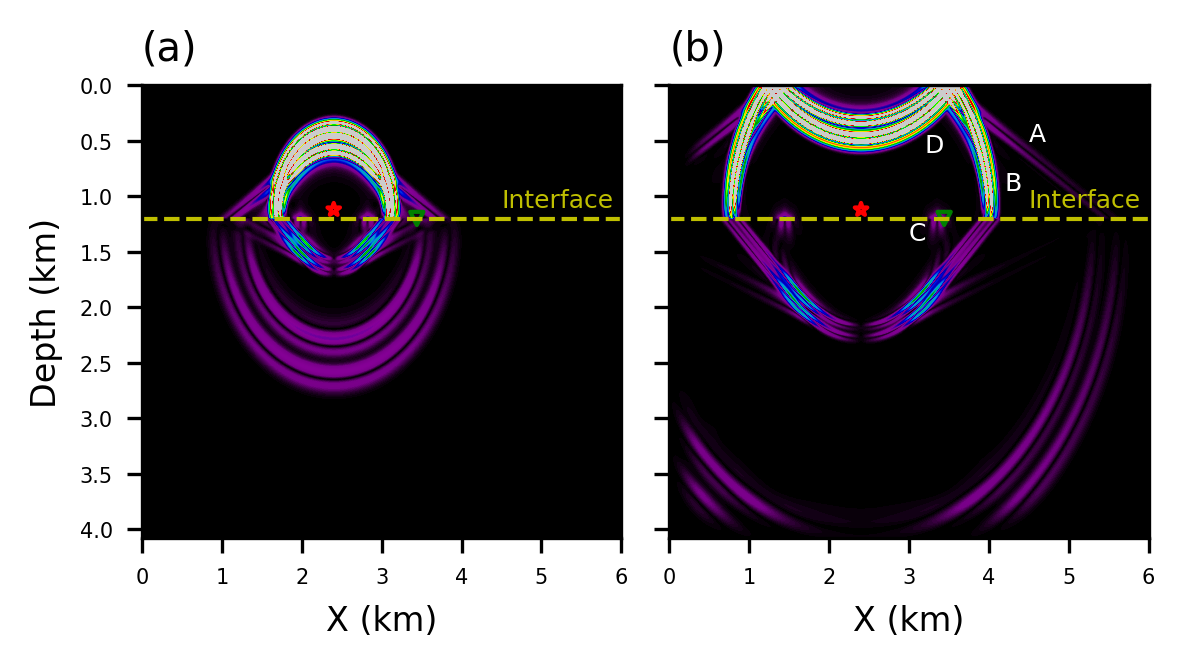

In [4]:
%matplotlib inline

rcParams['font.size'] = 8
rcParams['font.family'] = 'sans-serif'

fig, ax = plt.subplots(1,2,figsize=(4.33, 2),dpi=300)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0)
im1=ax[0].imshow(np.transpose(v1),interpolation='bilinear',aspect="auto",extent=[0,6,4.08,0],vmin=0,vmax=0.4,cmap='nipy_spectral')
im2=ax[1].imshow(np.transpose(v2),interpolation='bilinear',aspect="auto",extent=[0,6,4.08,0],vmin=0,vmax=0.4,cmap='nipy_spectral')
ax[0].set(xlabel='X (km)',ylabel='Depth (km)')
ax[1].set(xlabel='X (km)')
#ax[0].set_title('(a) t=0.7 sec',loc='center',y=-0.5)
#ax[1].set_title('(b) t=1.2 sec',loc='center',y=-0.5)
#ax[0].set_title('(a) t=0.7 sec',loc='center')
#ax[1].set_title('(b) t=1.2 sec',loc='center')
ax[0].set_title('(a)',loc='left')
ax[1].set_title('(b)',loc='left')
ax[0].tick_params(axis='both', which='major', labelsize=5)
ax[1].tick_params(axis='both', which='major', labelsize=5)
ax[1].set_yticklabels([])

ax[0].hlines(1.205,0,6,colors='y',linestyles='--',Linewidth=1)
ax[0].scatter([2.4], [1.12],marker='*',edgecolors='r',facecolors='none',s=10)
ax[0].scatter([3.44],[1.2],marker='v',edgecolors='g',facecolors='none',s=10)
ax[1].hlines(1.205,0,6,colors='y',linestyles='--',Linewidth=1)
ax[1].scatter([2.4], [1.12],marker='*',edgecolors='r',facecolors='none',s=10)
ax[1].scatter([3.44],[1.2],marker='v',edgecolors='g',facecolors='none',s=10)

ax[0].annotate('Interface',xy=(4.5,1.1),fontsize=6,c='y')
ax[1].annotate('Interface',xy=(4.5,1.1),fontsize=6,c='y')
ax[1].annotate("A",xy=(4.5,0.5),c='w',fontsize=6)
ax[1].annotate("B",xy=(4.2,0.95),c='w',fontsize=6)
ax[1].annotate("C",xy=(3,1.4),c='w',fontsize=6)
ax[1].annotate("D",xy=(3.2,0.6),c='w',fontsize=6)
#ax[1].annotate("E",xy=(3,3.4),c='w',fontsize=6)
#ax[1].annotate("E",xy=(0.8,3),c='w',fontsize=6)

#plt.show()
#plt.savefig('../fig/wavefields.png',bbox_inches='tight',format='png')

### Seismogram figures SBP-SAT vs SPECFEM2D vs Devito

In [5]:
# load SBP-SAT and SPECFEM2D seismograms
fd=np.load('../dat/fd_data.npy')
spec_vx=np.loadtxt('../dat/specfem2d_data_vx.txt')
spec_vz=np.loadtxt('../dat/specfem2d_data_vz.txt')
spec_p=np.loadtxt('../dat/specfem2d_data_p.txt')
fd2=np.load('../dat/fd_data2.npy')
spec2_vx=np.loadtxt('../dat/specfem2d_data2_vx.txt')
spec2_vz=np.loadtxt('../dat/specfem2d_data2_vz.txt')
spec2_p=np.loadtxt('../dat/specfem2d_data2_p.txt')
fd3=np.load('../dat/fd_data3.npy')
spec3_vx=np.loadtxt('../dat/specfem2d_data3_vx.txt')
spec3_vz=np.loadtxt('../dat/specfem2d_data3_vz.txt')
spec3_p=np.loadtxt('../dat/specfem2d_data3_p.txt')
devito1=np.load('../dat/devito.npy')
devito2=np.load('../dat/devito2.npy')
devito3=np.load('../dat/devito3.npy')

# calibrate SPECFEM2D amplitudes (because different physical units are used)
spec_vx=2.25*10**12*spec_vx[:,1]
spec_vz=-2.25*10**12*spec_vz[:,1]
spec_p=-2.25*10**6*np.gradient(spec_p[:,1],dt) # from fluid potential to calibrated hydraulic pressure

spec2_vx=2.25*10**12*spec2_vx[:,1]
spec2_vz=-2.25*10**12*spec2_vz[:,1]
spec2_p=-2.25*10**6*np.gradient(spec2_p[:,1],dt)

spec3_vx=2.25*10**12*spec3_vx[:,1]
spec3_vz=-2.25*10**12*spec3_vz[:,1]
spec3_p=-2.25*10**6*np.gradient(spec3_p[:,1],dt)

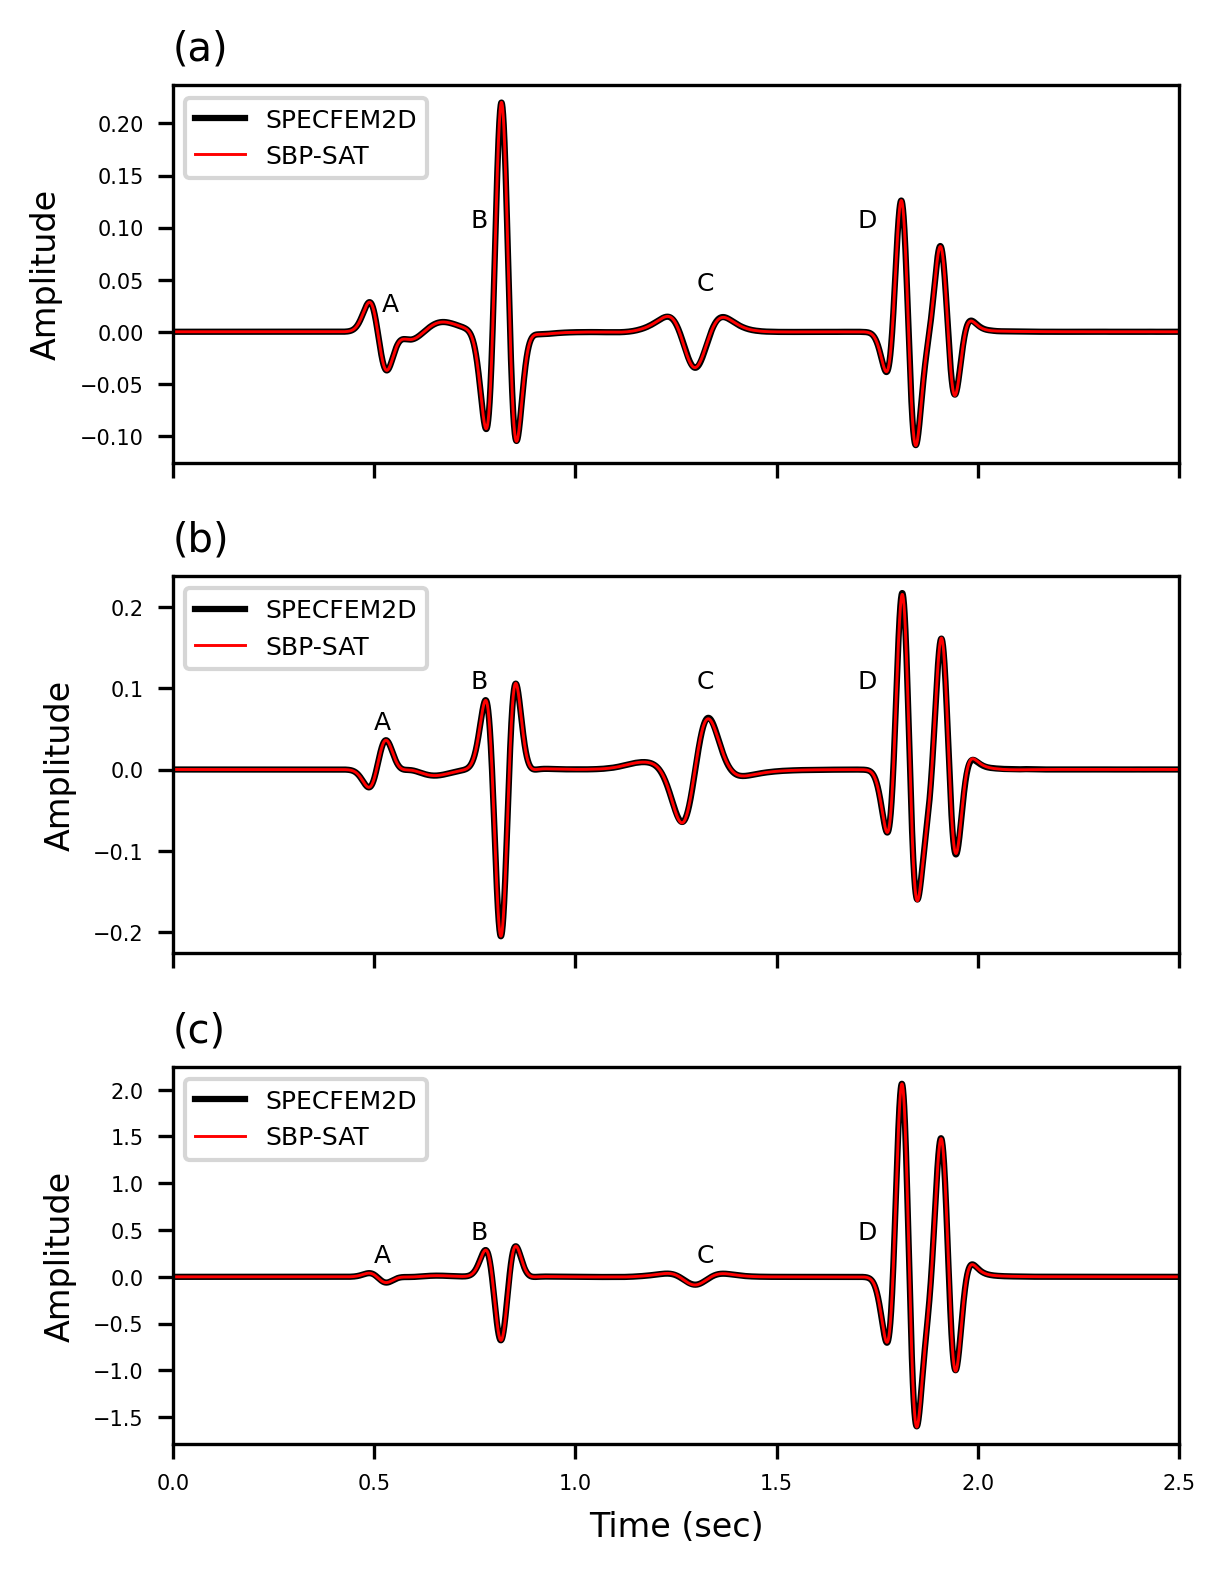

In [6]:
%matplotlib inline

rcParams['font.size'] = 8
rcParams['font.family'] = 'sans-serif'

fig, ax = plt.subplots(3,1,figsize=(4.33, 6),dpi=300)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
l,=ax[0].plot(np.linspace(ot,(nt-1)*dt,nt),spec_vx,linestyle='-',linewidth=1.5,c='k')
l.set_label("SPECFEM2D")
l,=ax[0].plot(np.linspace(ot,(nt-1)*dt,nt),fd[1,0,:],linestyle='-',linewidth=0.7,c='r')
l.set_label("SBP-SAT")
l,=ax[1].plot(np.linspace(ot,(nt-1)*dt,nt),spec_vz,linestyle='-',linewidth=1.5,c='k')
l.set_label("SPECFEM2D")
l,=ax[1].plot(np.linspace(ot,(nt-1)*dt,nt),fd[2,0,:],linestyle='-',linewidth=0.7,c='r')
l.set_label("SBP-SAT")
l,=ax[2].plot(np.linspace(ot,(nt-1)*dt,nt),spec_p,linestyle='-',linewidth=1.5,c='k')
l.set_label("SPECFEM2D")
l,=ax[2].plot(np.linspace(ot,(nt-1)*dt,nt),fd[0,0,:],linestyle='-',linewidth=0.7,c='r')
l.set_label("SBP-SAT")

ax[0].set_xlim(0,ot+(nt-1)*dt)
ax[1].set_xlim(0,ot+(nt-1)*dt)
ax[2].set_xlim(0,ot+(nt-1)*dt)

ax[0].set(ylabel='Amplitude')
ax[1].set(ylabel='Amplitude')
ax[2].set(xlabel='Time (sec)',ylabel='Amplitude')

#ax[0].set_title(r'(a) $v_x$ component',loc='left')
#ax[1].set_title(r'(b) $v_z$ component',loc='left')
#ax[2].set_title(r'(c) Pressure component',loc='left')
ax[0].set_title(r'(a)',loc='left')
ax[1].set_title(r'(b)',loc='left')
ax[2].set_title(r'(c)',loc='left')

ax[0].tick_params(axis='both', which='major', labelsize=5)
ax[1].tick_params(axis='both', which='major', labelsize=5)
ax[2].tick_params(axis='both', which='major', labelsize=5)

ax[0].set_xticklabels([])
ax[1].set_xticklabels([])

ax[0].legend(loc='upper left',prop={'size': 6})
ax[1].legend(loc='upper left',prop={'size': 6})
ax[2].legend(loc='upper left',prop={'size': 6})

ax[0].annotate("A",xy=(0.52,0.02),c='k',fontsize=6)
ax[0].annotate("B",xy=(0.74,0.1),c='k',fontsize=6)
ax[0].annotate("C",xy=(1.3,0.04),c='k',fontsize=6)
ax[0].annotate("D",xy=(1.7,0.1),c='k',fontsize=6)

ax[1].annotate("A",xy=(0.5,0.05),c='k',fontsize=6)
ax[1].annotate("B",xy=(0.74,0.1),c='k',fontsize=6)
ax[1].annotate("C",xy=(1.3,0.1),c='k',fontsize=6)
ax[1].annotate("D",xy=(1.7,0.1),c='k',fontsize=6)

ax[2].annotate("A",xy=(0.5,0.16),c='k',fontsize=6)
ax[2].annotate("B",xy=(0.74,0.4),c='k',fontsize=6)
ax[2].annotate("C",xy=(1.3,0.16),c='k',fontsize=6)
ax[2].annotate("D",xy=(1.7,0.4),c='k',fontsize=6)

#plt.show()
#plt.savefig('../fig/seismograms1.png',bbox_inches='tight',format='png')

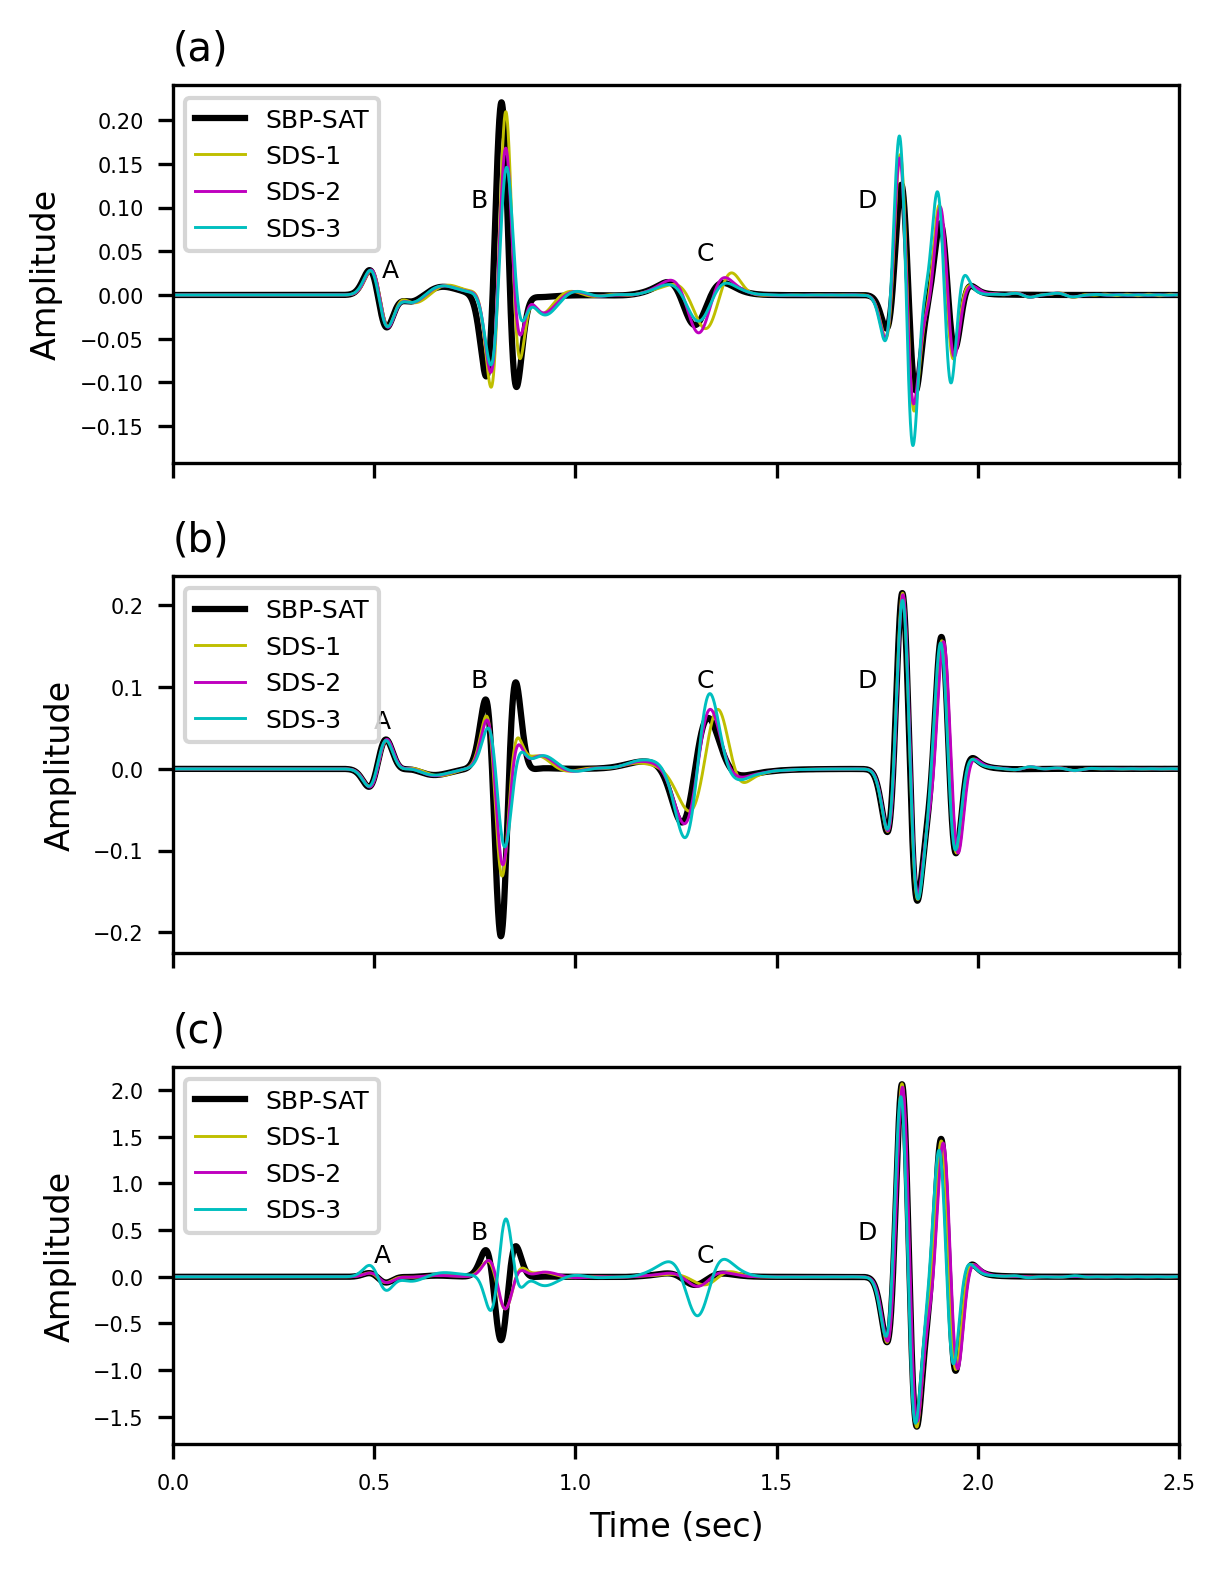

In [7]:
%matplotlib inline

rcParams['font.size'] = 8
rcParams['font.family'] = 'sans-serif'

fig, ax = plt.subplots(3,1,figsize=(4.33, 6),dpi=300)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
l,=ax[0].plot(np.linspace(ot,(nt-1)*dt,nt),fd[1,0,:],linestyle='-',linewidth=1.5,c='k')
l.set_label("SBP-SAT")
l,=ax[0].plot(np.linspace(ot,(nt-1)*dt,nt),devito1[1,:],linestyle='-',linewidth=0.7,c='y')
l.set_label("SDS-1")
l,=ax[0].plot(np.linspace(ot,(nt-1)*dt,nt),devito2[1,:],linestyle='-',linewidth=0.7,c='m')
l.set_label("SDS-2")
l,=ax[0].plot(np.linspace(ot,(nt-1)*dt,nt),devito3[1,:],linestyle='-',linewidth=0.7,c='c')
l.set_label("SDS-3")
l,=ax[1].plot(np.linspace(ot,(nt-1)*dt,nt),fd[2,0,:],linestyle='-',linewidth=1.5,c='k')
l.set_label("SBP-SAT")
l,=ax[1].plot(np.linspace(ot,(nt-1)*dt,nt),devito1[2,:],linestyle='-',linewidth=0.7,c='y')
l.set_label("SDS-1")
l,=ax[1].plot(np.linspace(ot,(nt-1)*dt,nt),devito2[2,:],linestyle='-',linewidth=0.7,c='m')
l.set_label("SDS-2")
l,=ax[1].plot(np.linspace(ot,(nt-1)*dt,nt),devito3[2,:],linestyle='-',linewidth=0.7,c='c')
l.set_label("SDS-3")
l,=ax[2].plot(np.linspace(ot,(nt-1)*dt,nt),fd[0,0,:],linestyle='-',linewidth=1.5,c='k')
l.set_label("SBP-SAT")
l,=ax[2].plot(np.linspace(ot,(nt-1)*dt,nt),devito1[0,:],linestyle='-',linewidth=0.7,c='y')
l.set_label("SDS-1")
l,=ax[2].plot(np.linspace(ot,(nt-1)*dt,nt),devito2[0,:],linestyle='-',linewidth=0.7,c='m')
l.set_label("SDS-2")
l,=ax[2].plot(np.linspace(ot,(nt-1)*dt,nt),devito3[0,:],linestyle='-',linewidth=0.7,c='c')
l.set_label("SDS-3")

ax[0].set_xlim(0,ot+(nt-1)*dt)
ax[1].set_xlim(0,ot+(nt-1)*dt)
ax[2].set_xlim(0,ot+(nt-1)*dt)

ax[0].set(ylabel='Amplitude')
ax[1].set(ylabel='Amplitude')
ax[2].set(xlabel='Time (sec)',ylabel='Amplitude')

#ax[0].set_title(r'(a) $v_x$ component',loc='left')
#ax[1].set_title(r'(b) $v_z$ component',loc='left')
#ax[2].set_title(r'(c) Pressure component',loc='left')
ax[0].set_title(r'(a)',loc='left')
ax[1].set_title(r'(b)',loc='left')
ax[2].set_title(r'(c)',loc='left')

ax[0].tick_params(axis='both', which='major', labelsize=5)
ax[1].tick_params(axis='both', which='major', labelsize=5)
ax[2].tick_params(axis='both', which='major', labelsize=5)

ax[0].set_xticklabels([])
ax[1].set_xticklabels([])

ax[0].legend(loc='upper left',prop={'size': 6})
ax[1].legend(loc='upper left',prop={'size': 6})
ax[2].legend(loc='upper left',prop={'size': 6})

ax[0].annotate("A",xy=(0.52,0.02),c='k',fontsize=6)
ax[0].annotate("B",xy=(0.74,0.1),c='k',fontsize=6)
ax[0].annotate("C",xy=(1.3,0.04),c='k',fontsize=6)
ax[0].annotate("D",xy=(1.7,0.1),c='k',fontsize=6)

ax[1].annotate("A",xy=(0.5,0.05),c='k',fontsize=6)
ax[1].annotate("B",xy=(0.74,0.1),c='k',fontsize=6)
ax[1].annotate("C",xy=(1.3,0.1),c='k',fontsize=6)
ax[1].annotate("D",xy=(1.7,0.1),c='k',fontsize=6)

ax[2].annotate("A",xy=(0.5,0.16),c='k',fontsize=6)
ax[2].annotate("B",xy=(0.74,0.4),c='k',fontsize=6)
ax[2].annotate("C",xy=(1.3,0.16),c='k',fontsize=6)
ax[2].annotate("D",xy=(1.7,0.4),c='k',fontsize=6)

#plt.show()
#plt.savefig('../fig/seismograms2.png',bbox_inches='tight',format='png')

### Seismogram figures SBP-SAT vs SPECFEM2D coarsening test

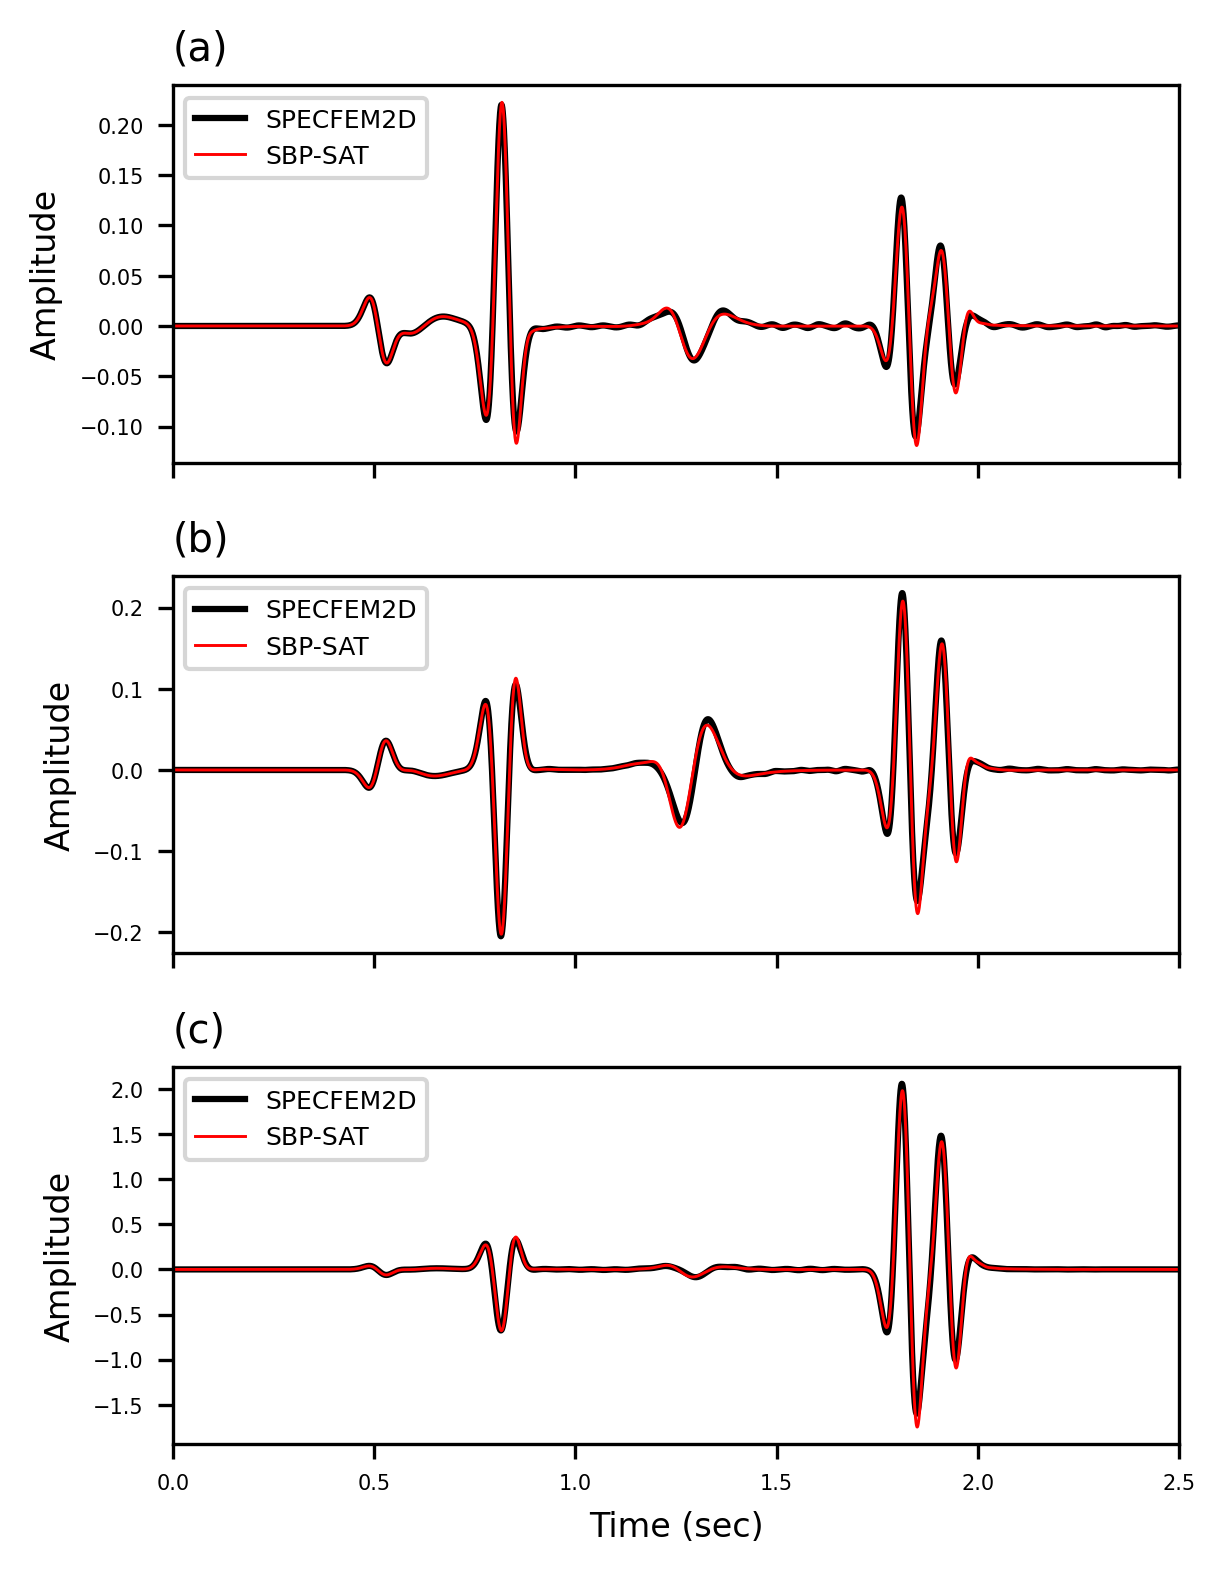

In [8]:
%matplotlib inline

rcParams['font.size'] = 8
rcParams['font.family'] = 'sans-serif'

fig, ax = plt.subplots(3,1,figsize=(4.33, 6),dpi=300)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
l,=ax[0].plot(np.linspace(ot,(nt-1)*dt,nt),spec2_vx,linestyle='-',linewidth=1.5,c='k')
l.set_label("SPECFEM2D")
l,=ax[0].plot(np.linspace(ot,(nt-1)*dt,nt),fd2[1,0,:],linestyle='-',linewidth=0.7,c='r')
l.set_label("SBP-SAT")
l,=ax[1].plot(np.linspace(ot,(nt-1)*dt,nt),spec2_vz,linestyle='-',linewidth=1.5,c='k')
l.set_label("SPECFEM2D")
l,=ax[1].plot(np.linspace(ot,(nt-1)*dt,nt),fd2[2,0,:],linestyle='-',linewidth=0.7,c='r')
l.set_label("SBP-SAT")
l,=ax[2].plot(np.linspace(ot,(nt-1)*dt,nt),spec2_p,linestyle='-',linewidth=1.5,c='k')
l.set_label("SPECFEM2D")
l,=ax[2].plot(np.linspace(ot,(nt-1)*dt,nt),fd2[0,0,:],linestyle='-',linewidth=0.7,c='r')
l.set_label("SBP-SAT")

ax[0].set_xlim(0,ot+(nt-1)*dt)
ax[1].set_xlim(0,ot+(nt-1)*dt)
ax[2].set_xlim(0,ot+(nt-1)*dt)

ax[0].set(ylabel='Amplitude')
ax[1].set(ylabel='Amplitude')
ax[2].set(xlabel='Time (sec)',ylabel='Amplitude')

#ax[0].set_title(r'(a) $v_x$ component',loc='left')
#ax[1].set_title(r'(b) $v_z$ component',loc='left')
#ax[2].set_title(r'(c) Pressure component',loc='left')
ax[0].set_title(r'(a)',loc='left')
ax[1].set_title(r'(b)',loc='left')
ax[2].set_title(r'(c)',loc='left')

ax[0].tick_params(axis='both', which='major', labelsize=5)
ax[1].tick_params(axis='both', which='major', labelsize=5)
ax[2].tick_params(axis='both', which='major', labelsize=5)

ax[0].set_xticklabels([])
ax[1].set_xticklabels([])

ax[0].legend(loc='upper left',prop={'size': 6})
ax[1].legend(loc='upper left',prop={'size': 6})
ax[2].legend(loc='upper left',prop={'size': 6})


#plt.show()
#plt.savefig('../fig/seismograms3.png',bbox_inches='tight',format='png')

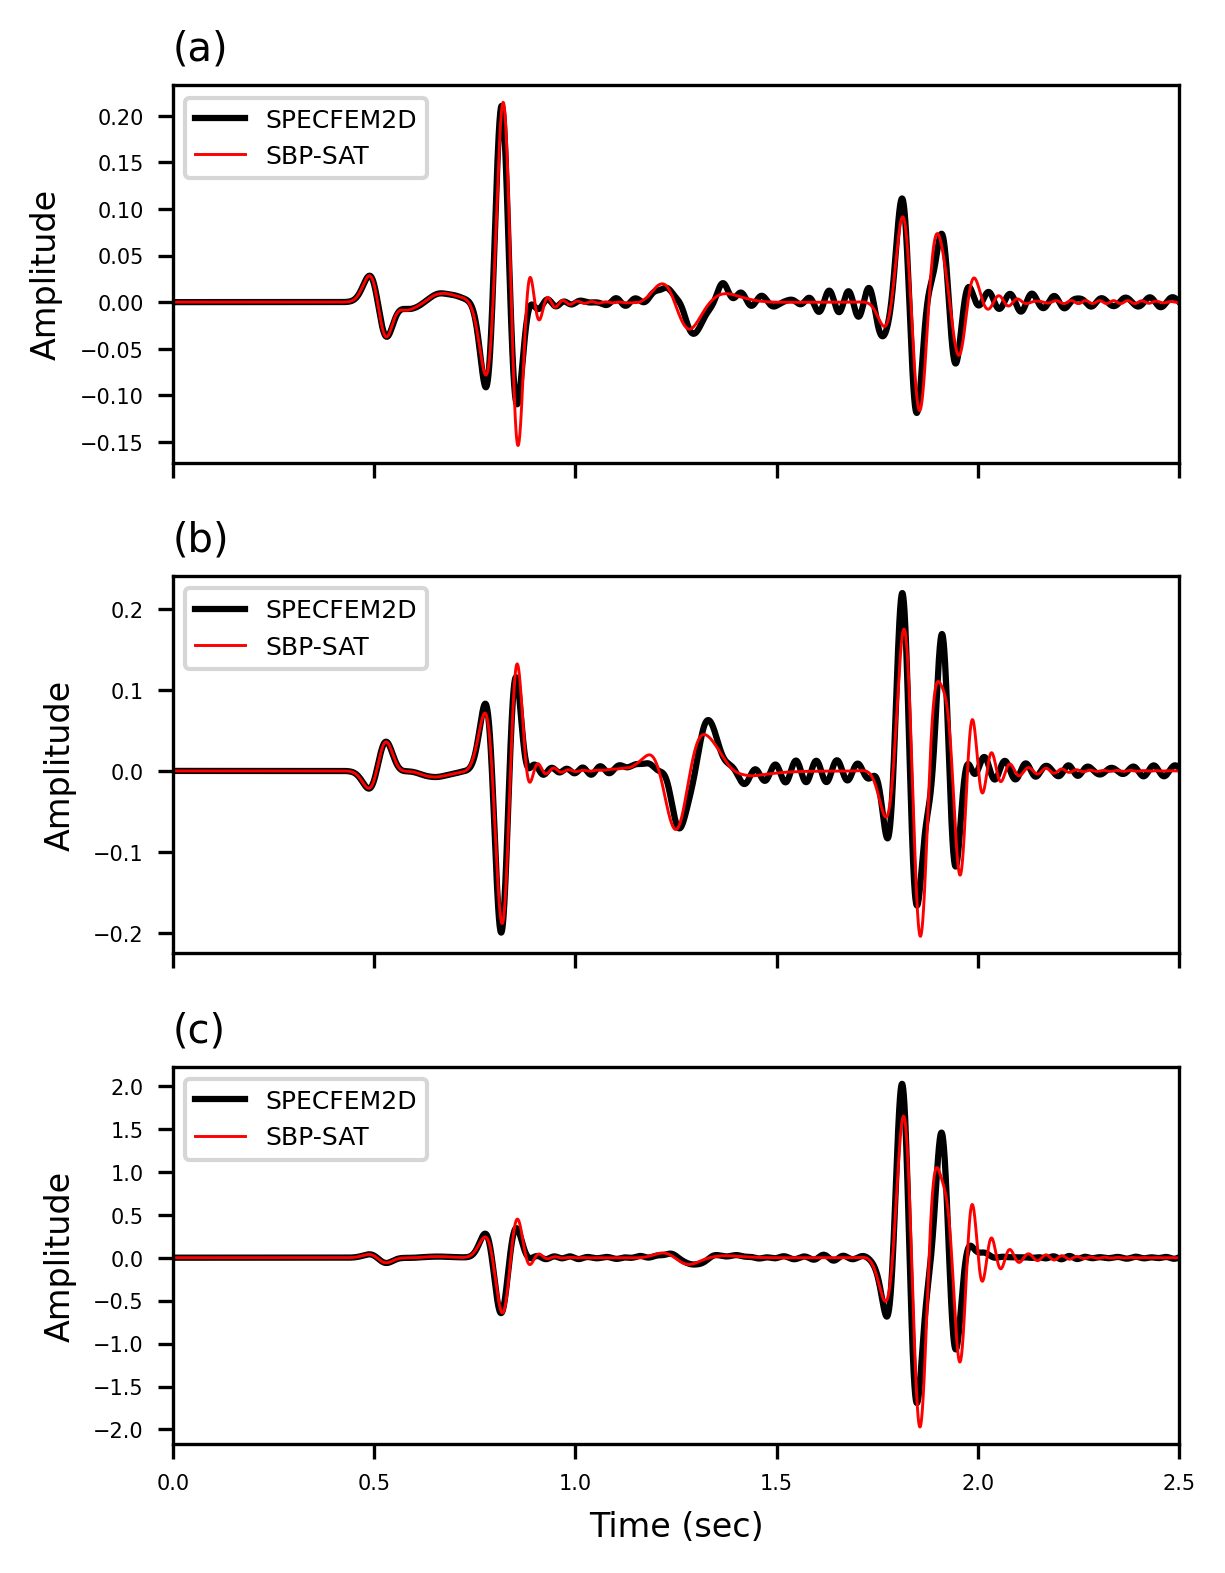

In [9]:
%matplotlib inline

rcParams['font.size'] = 8
rcParams['font.family'] = 'sans-serif'

fig, ax = plt.subplots(3,1,figsize=(4.33, 6),dpi=300)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
l,=ax[0].plot(np.linspace(ot,(nt-1)*dt,nt),spec3_vx,linestyle='-',linewidth=1.5,c='k')
l.set_label("SPECFEM2D")
l,=ax[0].plot(np.linspace(ot,(nt-1)*dt,nt),fd3[1,0,:],linestyle='-',linewidth=0.7,c='r')
l.set_label("SBP-SAT")
l,=ax[1].plot(np.linspace(ot,(nt-1)*dt,nt),spec3_vz,linestyle='-',linewidth=1.5,c='k')
l.set_label("SPECFEM2D")
l,=ax[1].plot(np.linspace(ot,(nt-1)*dt,nt),fd3[2,0,:],linestyle='-',linewidth=0.7,c='r')
l.set_label("SBP-SAT")
l,=ax[2].plot(np.linspace(ot,(nt-1)*dt,nt),spec3_p,linestyle='-',linewidth=1.5,c='k')
l.set_label("SPECFEM2D")
l,=ax[2].plot(np.linspace(ot,(nt-1)*dt,nt),fd3[0,0,:],linestyle='-',linewidth=0.7,c='r')
l.set_label("SBP-SAT")

ax[0].set_xlim(0,ot+(nt-1)*dt)
ax[1].set_xlim(0,ot+(nt-1)*dt)
ax[2].set_xlim(0,ot+(nt-1)*dt)

ax[0].set(ylabel='Amplitude')
ax[1].set(ylabel='Amplitude')
ax[2].set(xlabel='Time (sec)',ylabel='Amplitude')

#ax[0].set_title(r'(a) $v_x$ component',loc='left')
#ax[1].set_title(r'(b) $v_z$ component',loc='left')
#ax[2].set_title(r'(c) Pressure component',loc='left')
ax[0].set_title(r'(a)',loc='left')
ax[1].set_title(r'(b)',loc='left')
ax[2].set_title(r'(c)',loc='left')

ax[0].tick_params(axis='both', which='major', labelsize=5)
ax[1].tick_params(axis='both', which='major', labelsize=5)
ax[2].tick_params(axis='both', which='major', labelsize=5)

ax[0].set_xticklabels([])
ax[1].set_xticklabels([])

ax[0].legend(loc='upper left',prop={'size': 6})
ax[1].legend(loc='upper left',prop={'size': 6})
ax[2].legend(loc='upper left',prop={'size': 6})


#plt.show()
#plt.savefig('../fig/seismograms4.png',bbox_inches='tight',format='png')

### Difference and error values

In [10]:
# relative difference between SBP-SAT and SPECFEM2D
# ||sbp-sem||/||sem||
difference=np.zeros((3))
difference[0]=np.linalg.norm(fd[1,0,:]-spec_vx)/np.linalg.norm(spec_vx)
difference[1]=np.linalg.norm(fd[2,0,:]-spec_vz)/np.linalg.norm(spec_vz)
difference[2]=np.linalg.norm(fd[0,0,:]-spec_p)/np.linalg.norm(spec_p)

# Error between coarse and fine grid
# ||coarse-dense||/||dense||
error_sbp=np.zeros((2,3))
error_sbp[0,0]=np.linalg.norm(fd2[1,0,:]-fd[1,0,:])/np.linalg.norm(fd[1,0,:])
error_sbp[0,1]=np.linalg.norm(fd2[2,0,:]-fd[2,0,:])/np.linalg.norm(fd[2,0,:])
error_sbp[0,2]=np.linalg.norm(fd2[0,0,:]-fd[0,0,:])/np.linalg.norm(fd[0,0,:])
error_sbp[1,0]=np.linalg.norm(fd3[1,0,:]-fd[1,0,:])/np.linalg.norm(fd[1,0,:])
error_sbp[1,1]=np.linalg.norm(fd3[2,0,:]-fd[2,0,:])/np.linalg.norm(fd[2,0,:])
error_sbp[1,2]=np.linalg.norm(fd3[0,0,:]-fd[0,0,:])/np.linalg.norm(fd[0,0,:])

error_sem=np.zeros((2,3))
error_sem[0,0]=np.linalg.norm(spec2_vx-spec_vx)/np.linalg.norm(spec_vx)
error_sem[0,1]=np.linalg.norm(spec2_vz-spec_vz)/np.linalg.norm(spec_vz)
error_sem[0,2]=np.linalg.norm(spec2_p-spec_p)/np.linalg.norm(spec_p)
error_sem[1,0]=np.linalg.norm(spec3_vx-spec_vx)/np.linalg.norm(spec_vx)
error_sem[1,1]=np.linalg.norm(spec3_vz-spec_vz)/np.linalg.norm(spec_vz)
error_sem[1,2]=np.linalg.norm(spec3_p-spec_p)/np.linalg.norm(spec_p)

In [11]:
print("Relative difference |sbp-sem|/|sem|\n vx:%.3f \t vz:%.3f \t p:%.3f" %(difference[0],difference[1],difference[2]))

Relative difference |sbp-sem|/|sem|
 vx:0.007 	 vz:0.012 	 p:0.014


In [12]:
print("Relative error for sbp coarsening x 2 |coarse-dense|/|dense|\n vx:%.3f \t vz:%.3f \t p:%.3f" %(error_sbp[0,0],error_sbp[0,1],error_sbp[0,2]))

Relative error for sbp coarsening x 2 |coarse-dense|/|dense|
 vx:0.096 	 vz:0.092 	 p:0.091


In [13]:
print("Relative error for sem coarsening x 2 |coarse-dense|/|dense|\n vx:%.3f \t vz:%.3f \t p:%.3f" %(error_sem[0,0],error_sem[0,1],error_sem[0,2]))

Relative error for sem coarsening x 2 |coarse-dense|/|dense|
 vx:0.030 	 vz:0.014 	 p:0.008


In [14]:
print("Relative error for sbp coarsening x 3 |coarse-dense|/|dense|\n vx:%.3f \t vz:%.3f \t p:%.3f" %(error_sbp[1,0],error_sbp[1,1],error_sbp[1,2]))

Relative error for sbp coarsening x 3 |coarse-dense|/|dense|
 vx:0.348 	 vz:0.380 	 p:0.433


In [15]:
print("Relative error for sem coarsening x 3 |coarse-dense|/|dense|\n vx:%.3f \t vz:%.3f \t p:%.3f" %(error_sem[1,0],error_sem[1,1],error_sem[1,2]))

Relative error for sem coarsening x 3 |coarse-dense|/|dense|
 vx:0.161 	 vz:0.130 	 p:0.061
